In [56]:
import tensorflow as tf
#import wave
import glob
import scipy.io.wavfile as wavfile
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
%matplotlib inline

In [57]:
global SMP_RATE
SMP_RATE = 16000

In [58]:
def getWaveName(wavepath):
    return wavepath.split('/')[-1]

def findWave(wavefile,path):
    r = glob.glob(path+wavefile)
    return r[0]

In [59]:
fpath = '../../cmu_artic/female_us_slt/' #desktop
mpath = '../../cmu_artic/male_us_bdl/' #desktop
# fpath = '../data/female_us/'
# mpath = '../data/male_us/'

# Hacky parallel dataset

In [60]:
# map male to female
m2f = dict()
for i in glob.glob(mpath+'/*.wav'):
    m2f[i]=findWave(getWaveName(i),fpath)

In [61]:
m2f.keys()[0]

'../../cmu_artic/male_us_bdl/arctic_b0515.wav'

# Bin before hand

In [7]:
bin_size_x = (2,3)
bin_size_y = (2,3)

In [8]:
bin_mapping = {}
for filename in glob.glob(mpath+'*.wav'):
    fm, wav_data = wavfile.read(filename)
    size = wav_data.shape[0]/(1.0*fm)
    if size < bin_size_x[1] and size > bin_size_x[0]:
        fm2, wav_data2 = wavfile.read(m2f[filename])
        size2 = wav_data2.shape[0]/(1.0*fm2)
        if size2 < bin_size_x[1] and size2 > bin_size_x[0]:
            bin_mapping[filename] = m2f[filename]

In [9]:
len(bin_mapping)

348

# Sec to Samples

In [10]:
def sec2samp(sec,smp_rate):
    return int(sec*smp_rate)

# Padding

In [11]:
def padTo(x,size,kind='SYM'):
    """
    Expects 1D array
    """
    assert kind in ['LEFT','RIGHT','SYM']
    if kind == 'LEFT':
        pad = np.zeros(size-len(x),dtype=x.dtype)
        r=np.concatenate((pad,x),axis=0)
    elif kind == 'RIGHT':
        pad = np.zeros(size-len(x),dtype=x.dtype)
        r=np.concatenate((x,pad),axis=0)
    elif kind == 'SYM':
        padl = np.zeros((size-len(x))/2,dtype=x.dtype)
        padr = np.zeros((size-len(x))/2+(size-len(x))%2,dtype=x.dtype)
        r = np.concatenate((padl,x,padr),axis=0)
    return r

# Batch Generator

convolution expects data of shape (batchsize,height,width,inchannel)

Data should be of shape (batchsize,height=1,time_length (this is width),inchannel=1)

In [12]:
class Batch(object):
    def __init__(self,mapping,bin_max,batch_size=1):
        self.mapping = mapping
        self.bin_max = bin_max
        self.batch_size = batch_size
        self.seq_size = self.bin_max*SMP_RATE
        self.shape = (self.batch_size,1,self.seq_size,1)
        self.x_list = mapping.keys()
        self.size = len(self.x_list) #data size
        self.cursors = [(self.size//self.batch_size)*i for i in range(self.batch_size)]
        
    def getBatch(self):
        #get the file names
        x_path = [self.x_list[c] for c in self.cursors]
        y_path = [self.mapping[xp] for xp in x_path]
        
        #Get the x,y files and pad
        x = np.empty(shape=(self.batch_size,1,self.seq_size,1))
        y = np.empty(shape=(self.batch_size,1,self.seq_size,1))
        for i,(xp,yp) in enumerate(zip(x_path,y_path)):
            _,x_raw=wavfile.read(xp)
            _,y_raw=wavfile.read(yp)
            x_pad = padTo(x_raw,self.bin_max*SMP_RATE)
            y_pad = padTo(y_raw,self.bin_max*SMP_RATE)
            x[i,0,:,0]=x_pad
            y[i,0,:,0]=y_pad
            
        #update cursor positions
        self.cursors = [(c+1)%self.size for c in self.cursors]
        return (x,y)

In [13]:
b = Batch(mapping=bin_mapping,bin_max=bin_size_x[1],batch_size=3)

# PReLU

In [14]:
def prelu(x,name='prelu'):
    in_shape = x.get_shape().as_list()
    with tf.variable_scope(name):
        alpha = tf.get_variable('alpha',in_shape[-1],
                               initializer=tf.constant_initializer(0.1),
                               dtype=tf.float32)
        pos = tf.nn.relu(x)
        neg = alpha * (x-tf.abs(x))*.5
        
        return pos + neg

# Batch Norm

In [15]:
def batch_norm(x,ri=[0,1,2],eps=.0001):
    xshp=x.get_shape().as_list()
    with tf.variable_scope('bn'):
        gamma = tf.get_variable('gamma',[xshp[-1]],initializer=tf.truncated_normal_initializer(0,.1))
        beta = tf.get_variable('beta',[xshp[-1]],initializer=tf.constant_initializer(1.))

        mu = tf.reduce_mean(x,ri,keep_dims=True)
        sigma = tf.reduce_mean(tf.square(x-mu),ri,keep_dims=True)
        x_hat = (x-mu)/(tf.sqrt(sigma+eps))
        y = gamma*x_hat+beta
    return y

# Set up Batch

In [16]:
b = Batch(mapping=bin_mapping,bin_max=bin_size_x[1],batch_size=32)

# Build Graph and give inputs

In [45]:
g = tf.Graph()
with g.as_default():
    #try None shapes
    x = tf.placeholder(tf.float32,shape=b.shape)
    y = tf.placeholder(tf.float32,shape=b.shape)

# Generator

In [46]:
def make_z(shape, mean=0., std=1., name='z'):
    z = tf.random_normal(shape, mean=mean, stddev=std,
                             name=name, dtype=tf.float32)
    return z

In [47]:
with g.as_default():
    def Gen(x,reuse=False):
        with tf.variable_scope('Generator') as scope:
            if reuse:
                scope.reuse_variables()
            #Down Colnvolutions
            #create variables
            with tf.variable_scope('in'):
                # Shape (height,width,inchannels,out_channels)
                #down convolutions operations
                with tf.variable_scope('l1'):
                    conv1=tf.get_variable('conv1',shape=[1,31,1,1],initializer=tf.truncated_normal_initializer(0,.01))
                    b1 = tf.get_variable('b1',shape=1,initializer=tf.constant_initializer(0.01))
                    l1=prelu(tf.nn.conv2d(batch_norm(x),conv1,strides=[1,1,2,1],padding='SAME')+b1)
                with tf.variable_scope('l2'):
                    conv2=tf.get_variable('conv2',shape=[1,31,1,16],initializer=tf.truncated_normal_initializer(0,.01))
                    b2 = tf.get_variable('b2',shape=16,initializer=tf.constant_initializer(0.01))
                    l2=prelu(tf.nn.conv2d(batch_norm(l1),conv2,strides=[1,1,2,1],padding='SAME')+b2)
                with tf.variable_scope('l3'):
                    conv3=tf.get_variable('conv3',shape=[1,31,16,32],initializer=tf.truncated_normal_initializer(0,.01))
                    b3 = tf.get_variable('b3',shape=32,initializer=tf.constant_initializer(0.01))
                    l3=prelu(tf.nn.conv2d(batch_norm(l2),conv3,strides=[1,1,2,1],padding='SAME')+b3)
                with tf.variable_scope('l4'):
                    conv4=tf.get_variable('conv4',shape=[1,31,32,32],initializer=tf.truncated_normal_initializer(0,.01))
                    b4 = tf.get_variable('b4',shape=32,initializer=tf.constant_initializer(0.01))
                    l4=prelu(tf.nn.conv2d(batch_norm(l3),conv4,strides=[1,1,2,1],padding='SAME')+b4)
                with tf.variable_scope('l5'):
                    conv5=tf.get_variable('conv5',shape=[1,31,32,64],initializer=tf.truncated_normal_initializer(0,.01))
                    b5 = tf.get_variable('b5',shape=64,initializer=tf.constant_initializer(0.01))
                    l5=prelu(tf.nn.conv2d(batch_norm(l4),conv5,strides=[1,1,2,1],padding='SAME')+b5)
                with tf.variable_scope('l6'):
                    conv6=tf.get_variable('conv6',shape=[1,31,64,64],initializer=tf.truncated_normal_initializer(0,.01))
                    b6 = tf.get_variable('b6',shape=64,initializer=tf.constant_initializer(0.01))
                    l6=prelu(tf.nn.conv2d(batch_norm(l5),conv6,strides=[1,1,2,1],padding='SAME')+b6)
                with tf.variable_scope('l7'):
                    conv7=tf.get_variable('conv7',shape=[1,31,64,128],initializer=tf.truncated_normal_initializer(0,.01))
                    b7 = tf.get_variable('b7',shape=128,initializer=tf.constant_initializer(0.01))
                    l7=prelu(tf.nn.conv2d(batch_norm(l6),conv7,strides=[1,1,2,1],padding='SAME')+b7)


            last_shape = l7.get_shape()
            es=int(last_shape[2]) #encoding size
            
            #generate z
            z = make_z(shape=last_shape)

            # Transpose Convolution
            #Create variables
            with tf.variable_scope('out'):
                # Shape (height,width,out_channels,input channels)
                with tf.variable_scope('dl7'):
                    dconv7 = tf.get_variable('dconv7',shape=[1,31,64,128],initializer=tf.truncated_normal_initializer(0,.01))
                    db7 = tf.get_variable('b7',shape=64,initializer=tf.constant_initializer(0.01))
                    dl7 = prelu(tf.nn.conv2d_transpose(batch_norm(l7+z),dconv7,output_shape=[b.batch_size,1,(2**1)*es,64],strides=[1,1,2,1])+db7)
                with tf.variable_scope('dl6'):
                    dconv6 = tf.get_variable('dconv6',shape=[1,31,64,64],initializer=tf.truncated_normal_initializer(0,.01))
                    db6 = tf.get_variable('b6',shape=64,initializer=tf.constant_initializer(0.01))
                    dl6 = prelu(tf.nn.conv2d_transpose(batch_norm(dl7),dconv6,output_shape=[b.batch_size,1,(2**2)*es,64],strides=[1,1,2,1])+db6)
                with tf.variable_scope('dl5'):
                    dconv5 = tf.get_variable('dconv5',shape=[1,31,32,64],initializer=tf.truncated_normal_initializer(0,.01))
                    db5 = tf.get_variable('b5',shape=32,initializer=tf.constant_initializer(0.01))
                    dl5 = prelu(tf.nn.conv2d_transpose(batch_norm(dl6),dconv5,output_shape=[b.batch_size,1,(2**3)*es,32],strides=[1,1,2,1])+db5)
                with tf.variable_scope('dl4'):
                    dconv4 = tf.get_variable('dconv4',shape=[1,31,32,32],initializer=tf.truncated_normal_initializer(0,.01))
                    db4 = tf.get_variable('b4',shape=32,initializer=tf.constant_initializer(0.01))
                    dl4 = prelu(tf.nn.conv2d_transpose(batch_norm(dl5),dconv4,output_shape=[b.batch_size,1,(2**4)*es,32],strides=[1,1,2,1])+db4)
                with tf.variable_scope('dl3'):
                    dconv3 = tf.get_variable('dconv3',shape=[1,31,16,32],initializer=tf.truncated_normal_initializer(0,.01))
                    db3 = tf.get_variable('b3',shape=16,initializer=tf.constant_initializer(0.01))
                    dl3 = prelu(tf.nn.conv2d_transpose(batch_norm(dl4),dconv3,output_shape=[b.batch_size,1,(2**5)*es,16],strides=[1,1,2,1])+db3)
                with tf.variable_scope('dl2'):
                    dconv2 = tf.get_variable('dconv2',shape=[1,31,1,16],initializer=tf.truncated_normal_initializer(0,.01))
                    db2 = tf.get_variable('b2',shape=1,initializer=tf.constant_initializer(0.01))
                    dl2 = prelu(tf.nn.conv2d_transpose(batch_norm(dl3),dconv2,output_shape=[b.batch_size,1,(2**6)*es,1],strides=[1,1,2,1])+db2)
                with tf.variable_scope('dl1'):
                    dconv1 = tf.get_variable('dconv1',shape=[1,31,1,1],initializer=tf.truncated_normal_initializer(0,.01))
                    db1 = tf.get_variable('b1',shape=1,initializer=tf.constant_initializer(0.01))
                    dl1 = tf.nn.conv2d_transpose(batch_norm(dl2),dconv1,output_shape=[b.batch_size,1,(2**7)*es,1],strides=[1,1,2,1])+db1
        return dl1
    

In [48]:
with g.as_default():
    G_x = Gen(x)

# Loss functions and Optimization ops

In [49]:
with g.as_default():
    #optimizer
    with tf.device('/gpu:1'):
        # original loss function
        loss = tf.reduce_mean(tf.square(G_x - y))
        optimizer = tf.train.AdamOptimizer(learning_rate=.0002)
    
        #original optimization
        opt = optimizer.minimize(loss)

        #initializer
        init = tf.global_variables_initializer()

        #saver
        saver = tf.train.Saver()

In [50]:
save_path = 'modelckpt/modelGAN.ckpt'

# Other

In [51]:
sess = tf.Session(graph=g,config=tf.ConfigProto(
      allow_soft_placement=True, log_device_placement=True))
sess.run(init)

# Train original (supervised training)

In [52]:
losses = []

In [ ]:
#num_steps = 5000*30*7 #big league training
num_steps = 300*10*1
save_step = 500*30*6
for i in tqdm(xrange(num_steps)):
    x_data,y_data = b.getBatch()
    fd = {x:x_data,y:y_data}
    _,l = sess.run([opt,loss],feed_dict=fd)
    losses.append(l)
    if i % save_step == 0:
        save_path = saver.save(sess, save_path)

 45%|████▍     | 1340/3000 [11:05<13:47,  2.01it/s]

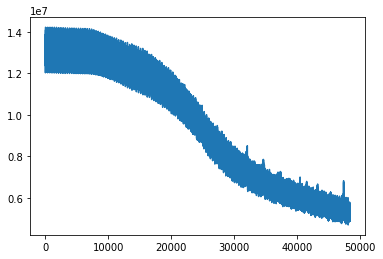

In [71]:
plt.plot(losses)

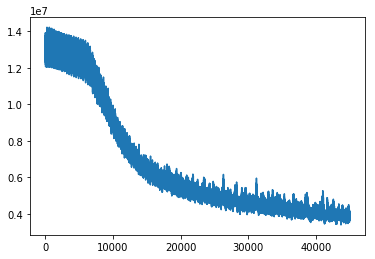

In [106]:
plt.plot(losses)

# Evaluate Data

In [63]:
with g.as_default():
    gen_audio = Gen(x,reuse=True)

In [64]:
x_data,y_data = b.getBatch() #uncomment if not training
fd = {x:x_data,y:y_data} #uncomment if not training
result = sess.run(gen_audio,feed_dict=fd)

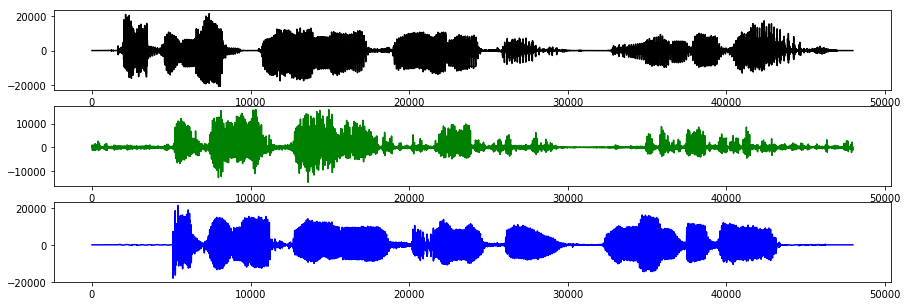

In [65]:
plt.figure(figsize=(15,5))
plt.subplot(311)
plt.plot(x_data[0,0,:,0],color='black')
plt.subplot(312)
plt.plot(result[0,0,:,0],color='green')
plt.subplot(313)
plt.plot(y_data[0,0,:,0],color='blue')

In [66]:
for i in g.get_collection('trainable_variables'):
    print i.name

Generator/in/l1/conv1:0
Generator/in/l1/b1:0
Generator/in/l1/bn/gamma:0
Generator/in/l1/bn/beta:0
Generator/in/l1/prelu/alpha:0
Generator/in/l2/conv2:0
Generator/in/l2/b2:0
Generator/in/l2/bn/gamma:0
Generator/in/l2/bn/beta:0
Generator/in/l2/prelu/alpha:0
Generator/in/l3/conv3:0
Generator/in/l3/b3:0
Generator/in/l3/bn/gamma:0
Generator/in/l3/bn/beta:0
Generator/in/l3/prelu/alpha:0
Generator/in/l4/conv4:0
Generator/in/l4/b4:0
Generator/in/l4/bn/gamma:0
Generator/in/l4/bn/beta:0
Generator/in/l4/prelu/alpha:0
Generator/in/l5/conv5:0
Generator/in/l5/b5:0
Generator/in/l5/bn/gamma:0
Generator/in/l5/bn/beta:0
Generator/in/l5/prelu/alpha:0
Generator/in/l6/conv6:0
Generator/in/l6/b6:0
Generator/in/l6/bn/gamma:0
Generator/in/l6/bn/beta:0
Generator/in/l6/prelu/alpha:0
Generator/in/l7/conv7:0
Generator/in/l7/b7:0
Generator/in/l7/bn/gamma:0
Generator/in/l7/bn/beta:0
Generator/in/l7/prelu/alpha:0
Generator/out/dl7/dconv7:0
Generator/out/dl7/b7:0
Generator/out/dl7/prelu/alpha:0
Generator/out/dl6/dcon

# Write to audio file

In [67]:
#generated
f = open('samples/generated_audio1.wav','wr')
wavfile.write(f,SMP_RATE,result[0,0,:,0].astype(np.int16))
f.close()

In [44]:
#original
f = open('samples/org_audio1.wav','wr')
wavfile.write(f,SMP_RATE,x_data[0,0,:,0].astype(np.int16))
f.close()

In [45]:
#target
f = open('samples/target_audio1.wav','wr')
wavfile.write(f,SMP_RATE,y_data[0,0,:,0].astype(np.int16))
f.close()